In [1]:
import pandas as pd
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

## Функции для анализа пересечения сегментов

In [23]:
def is_slf_intrsct(markup):    
    '''
    Функция is_slf_intrsct() определяет факт наличия пересечений
    сегментов внутри разметки markup. Требует один аргумент - разметку .deb.
    Возвращает True или False.
    '''
    
    # later should adapt for using lesser memory
    markup = markup.sort_values(by=[1], ascending=True)
    begin_list = list(markup[1])
    end_list = list(markup[2])
    slf_intrsct = False
    for zone_ in tqdm(range(1,len(begin_list))):
        if slf_intrsct == True:
            break
        if end_list[zone_ - 1] > begin_list[zone_]:
            slf_intrsct = True
    return slf_intrsct

def are_zones_intrsct(zone1, zone2):   
    '''
    Функция are_zones_intrsct() проверяет, пересекаются ли указанные 
    в аргументах отрезки zone1 и zone2. Отрезки должны списками или кортежами длины 2.
    Возвращает True или False.
    '''
    
    begin = 0
    end = 1
    intrsct = False
    
    if zone1[begin] > zone2[begin]:
        zonet = zone2
        zone2 = zone1
        zone1 = zonet
    
    def less_cmpr(x1, x2):
        if (x1 - x2) <= 0:
            return True
        else:
            return False
    
    if not all([less_cmpr(zone1[begin], zone2[begin]),
                less_cmpr(zone1[end], zone2[end]),
                less_cmpr(zone1[end], zone2[begin])]):
        intrsct = True
    return intrsct

def get_intrscts(markup1, markup2, ask_if=False):    
    '''
    Функция get_intrscts() строит матричное представление графа, построенного на
    отношениях пересечений между отрезками разметок markup1 и markup2.
    Возвращает объект pd.DataFrame. Если аргумент ask_if=True, то возвращает только True или False.
    '''
    
    begin_list_1 = list(markup1[1])
    end_list_1 = list(markup1[2])
    begin_list_2 = list(markup2[1])
    end_list_2 = list(markup2[2])
    df_intrsct = pd.DataFrame(0, index=[i for i in range(1,len(begin_list_2)+1)],
                               columns=[i for i in range(1,len(begin_list_1)+1)])
    for zone1 in tqdm(range(len(begin_list_1))):
        for zone2 in range(len(begin_list_2)):
            if are_zones_intrsct([begin_list_1[zone1], end_list_1[zone1]],
                                 [begin_list_2[zone2], end_list_2[zone2]]):
                if ask_if:
                    return True
                df_intrsct.loc[zone2+1, zone1+1] = 1
    return df_intrsct

def get_comm_intrsct(segm1, segm2):    
    '''
    Функция get_comm_intrsct() возвращает отрезок, являющийся пересечением
    отрезков segm1 и segm2.
    '''
    
    begin = 0
    end = 1
    
    if not are_zones_intrsct(segm1, segm2):
        print('Segments do not intersect')
        return 0
    
    if segm2[begin] < segm1[begin]:
        segmt = segm2
        segm2 = segm1
        segm1 = segmt
    
    def less_cmpr(x1, x2):
        if (x1 - x2) <= 0:
            return True
        else:
            return False
    
    def which_case():
        nonlocal segm1, segm2
        if all([less_cmpr(segm2[begin], segm1[end]),
                less_cmpr(segm1[end], segm2[end])]):
            return 1
        if all([less_cmpr(segm2[begin], segm1[end]),
                less_cmpr(segm2[end], segm1[end])]):
            return 2
        else:
            return 0
    
    intrsct_case = which_case()
    if not intrsct_case:
        # print('Segments do not intersect correctly')
        return 0
    if intrsct_case == 1:
        return [segm2[begin], segm1[end]]
    if intrsct_case == 2:
        return [segm2[begin], segm2[end]]
    else:
        print('Smth is wrong')
        return 0
    
def build_intrscts(markup1, markup2, progr_off=False):   
    '''
    Функция build_intrscts() строит .deb разметку на основе пересечения двух разметок
    markup1 и markup2. Возвращает объект pd.DataFrame.
    '''
    
    begin_list_1 = list(markup1[1])
    end_list_1 = list(markup1[2])
    begin_list_2 = list(markup2[1])
    end_list_2 = list(markup2[2])
    markup1_len = 0
    markup2_len = 0
    intrsct_len = 0
    
    intrsct_markup = pd.DataFrame(columns=[0, 1, 2])
    
    # if markup2[0][0] != markup1[0][0]:
    if markup2.iat[0, 0] != markup1.iat[0, 0]:
        if input('Different chromosomes if files. If no,\
        process will be stopped, else will be used name from 1-st file') == 'no':
            return 0
    # chr_name = markup1[0][0]
    chr_name = markup1.iat[0, 0]
    
    for zone1 in tqdm(range(len(begin_list_1)), disable=progr_off):
        for zone2 in range(len(begin_list_2)):
            segm1 = [begin_list_1[zone1], end_list_1[zone1]]
            segm2 = [begin_list_2[zone2], end_list_2[zone2]]
            markup1_len += segm1[1] - segm1[0]
            markup2_len += segm2[1] - segm2[0]
            if are_zones_intrsct(segm1, segm2):
                intrsct_zone = get_comm_intrsct(segm1, segm2)
                intrsct_markup = pd.concat([intrsct_markup,
                                            pd.DataFrame([[chr_name] + intrsct_zone],
                                                         columns=[0, 1, 2])], ignore_index=True)
                intrsct_len += intrsct_zone[1] - intrsct_zone[0]
    intrsct_markup.sort_values(by=[1], ascending=True, inplace=True)
#     print('Общая разметка составляет ', 100*intrsct_len/markup1_len,'% и ',
#           100*intrsct_len/markup2_len, '% от исходных')
    return intrsct_markup

def segmentation_intrsct(markup1, markup2, chr_length=0, n_segments=10, progr_off=False):
    '''
    Функция segmentation_intrsct() строит .deb разметку на основе пересечения двух разметок
    markup1 и markup2, задействуя алгоритм деления на отрезки. Опционально использует
    длину хромосомы и количество отрезков.
    '''
    
    if not chr_length:
        chr_length = max(list(markup1[2])[-1], list(markup2[2])[-1])
    
    intrsct_markup = pd.DataFrame(columns=[0, 1, 2])
    segments_lst = []
    for _s in range(1,n_segments+1):
        segments_lst.append(_s * (chr_length // n_segments))
    segments_lst[-1] += chr_length % n_segments
    for _s in tqdm(segments_lst, disable=progr_off):
        markup1_tmp = markup1.loc[(markup1[2] <= _s)]
        markup2_tmp = markup2.loc[(markup2[2] <= _s)]
        if markup1_tmp.empty or markup2_tmp.empty:
            continue
        markup1 = markup1.loc[(markup1[2] > _s)]
        markup2 = markup2.loc[(markup2[2] > _s)]
        intrsct_markup = pd.concat([intrsct_markup, build_intrscts(markup1_tmp, markup2_tmp, progr_off=True)])
    
    return intrsct_markup

In [25]:
print(is_slf_intrsct.__doc__)
print(are_zones_intrsct.__doc__)
print(get_intrscts.__doc__)
print(get_comm_intrsct.__doc__)
print(build_intrscts.__doc__)
print(segmentation_intrsct.__doc__)


    Функция is_slf_intrsct() определяет факт наличия пересечений
    сегментов внутри разметки markup. Требует один аргумент - разметку .deb.
    Возвращает True или False.
    

    Функция are_zones_intrsct() проверяет, пересекаются ли указанные 
    в аргументах отрезки zone1 и zone2. Отрезки должны списками или кортежами длины 2.
    Возвращает True или False.
    

    Функция get_intrscts() строит матричное представление графа, построенного на
    отношениях пересечений между отрезками разметок markup1 и markup2.
    Возвращает объект pd.DataFrame. Если аргумент ask_if=True, то возвращает только True или False.
    

    Функция get_comm_intrsct() возвращает отрезок, являющийся пересечением
    отрезков segm1 и segm2.
    

    Функция build_intrscts() строит .deb разметку на основе пересечения двух разметок
    markup1 и markup2. Возвращает объект pd.DataFrame.
    

    Функция segmentation_intrsct() строит .deb разметку на основе пересечения двух разметок
    markup1 и markup

___

In [6]:
pd.read_csv(wrk_dir+'chr_lengths.txt', sep="\t", header=None)

,0
0,30427671
1,19698289
2,23459830
3,18585056
4,26975502


In [14]:
old_intrscts = build_intrscts(markup_tair.loc[(markup_tair[3] == '+') & (markup_tair[0] == 'chr1')],
                              markup_real_2)

100%|██████████████████████████████████████████████████████████████████████████████| 3558/3558 [00:40<00:00, 88.56it/s]


In [36]:
segm_test_intrsct = segmentation_intrsct(markup_tair.loc[(markup_tair[3] == '+') & (markup_tair[0] == 'chr1')],
                                         markup_real_2,
                                         chr_length=30427671, n_segments=10)

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:07<00:00,  1.31it/s]


## Работа с реальными разметками

In [13]:
markup_tair

,0,1,2,3,4
0,chr1,1631,3631,+,AT1G01010
1,chr1,8737,10737,-,AT1G01020
2,chr1,13714,15714,-,AT1G01030
3,chr1,21146,23146,+,AT1G01040
4,chr1,33153,35153,-,AT1G01050
...,...,...,...,...,...
27197,chr5,26960323,26962323,-,AT5G67600
27198,chr5,26963638,26965638,-,AT5G67610
27199,chr5,26965996,26967996,-,AT5G67620
27200,chr5,26969394,26971394,-,AT5G67630


In [8]:
markup_tair = pd.read_csv("списки генов/ups2000_tair10.bed", sep="\t", header=None)

(array([34., 31., 32., 30., 30., 23., 23., 20., 33., 31., 29., 29., 22.,
        29., 33., 29., 21., 25., 25., 39., 30., 34., 22., 36., 27., 25.,
        39., 35., 41., 28., 22., 36., 29., 23., 30., 26., 27., 27., 27.,
        29., 29., 26., 32., 32., 16., 36., 37., 22., 24., 21., 34., 26.,
        18., 27., 22., 16., 17., 25., 29., 22., 25., 23., 16., 14., 18.,
         7.,  7.,  6.,  6.,  8.,  0.,  1.,  0.,  0.,  1.,  1.,  0.,  2.,
         6., 11., 11., 11.,  9., 19., 18., 24., 24., 20., 25., 31., 23.,
        23., 23., 37., 26., 11., 33., 26., 27., 37., 28., 30., 17., 23.,
        22., 19., 19., 23., 22., 17., 22., 23., 26., 19., 27., 27., 24.,
        33., 33., 26., 21., 18., 30., 16., 17., 34., 22., 27., 26., 21.,
        23., 32., 32., 35., 26., 29., 35., 30., 30., 26., 29., 23., 24.,
        26., 29., 27., 21., 21., 32., 34.]),
 array([1.63100000e+03, 2.04436267e+05, 4.07241533e+05, 6.10046800e+05,
        8.12852067e+05, 1.01565733e+06, 1.21846260e+06, 1.42126787e+06,
        

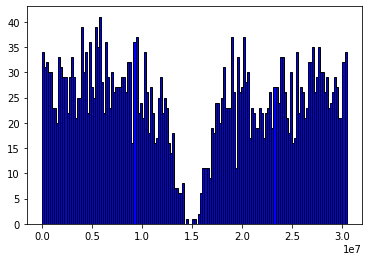

In [38]:
plt.hist(markup_tair.loc[(markup_tair[3] == '+') & (markup_tair[0] == 'chr1')][1], color = 'blue', edgecolor = 'black', bins=150)

In [9]:
# markup_real_1 = pd.read_csv("DHS/DHS_Ath_flower_14_days_chr1.bed", sep="\t", header=None)
markup_real_2 = pd.read_csv("GSM2704255_ATAC_seq/GSM2704255_ATAC_chr1.bed", sep="\t", header=None)

In [30]:
markup_real_2

,0,1,2,3,4
0,chr1,33153,33510,+,1
1,chr1,37877,38336,+,2
2,chr1,55331,55668,+,3
3,chr1,57011,57250,+,4
4,chr1,88271,88615,+,5
...,...,...,...,...,...
6191,chr1,30376215,30376513,+,6192
6192,chr1,30383455,30383646,+,6193
6193,chr1,30387674,30387865,+,6194
6194,chr1,30389342,30389533,+,6195


(array([ 81.,  90.,  81., 102.,  83., 115., 148., 140., 136., 117., 141.,
        141., 183., 168., 141., 165., 194., 163., 171., 174.,  95.,  84.,
         34.,  24.,  12.,  10.,  23., 106., 124., 178., 122., 142., 156.,
        116., 141., 103., 131., 183., 180., 152., 199., 173., 179., 173.,
        138.,  83., 125.,  96., 123.,  57.]),
 array([   33153. ,   640684.7,  1248216.4,  1855748.1,  2463279.8,
         3070811.5,  3678343.2,  4285874.9,  4893406.6,  5500938.3,
         6108470. ,  6716001.7,  7323533.4,  7931065.1,  8538596.8,
         9146128.5,  9753660.2, 10361191.9, 10968723.6, 11576255.3,
        12183787. , 12791318.7, 13398850.4, 14006382.1, 14613913.8,
        15221445.5, 15828977.2, 16436508.9, 17044040.6, 17651572.3,
        18259104. , 18866635.7, 19474167.4, 20081699.1, 20689230.8,
        21296762.5, 21904294.2, 22511825.9, 23119357.6, 23726889.3,
        24334421. , 24941952.7, 25549484.4, 26157016.1, 26764547.8,
        27372079.5, 27979611.2, 28587142.9, 29

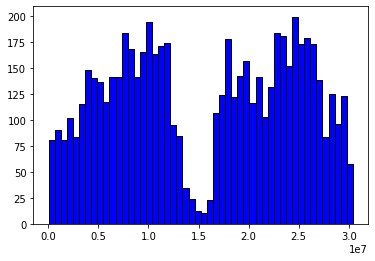

In [34]:
plt.hist(markup_real_2[1], color = 'blue', edgecolor = 'black', bins=50)

### Читаем разметку tair. Проверяем избыточность, т.е. что есть самопересечения.

In [6]:
for chr_name in ['chr1', 'chr2', 'chr3', 'chr4', 'chr5']:
    print(is_slf_intrsct(markup_tair.loc[(markup_tair[0] == chr_name) & (markup_tair[3] == '+')]))

  1%|▋                                                                            | 30/3148 [00:00<00:00, 25642.78it/s]

True
True
True
True
True


In [11]:
markup_tair = markup_tair.loc[(markup_tair[0] == 'chr1') & (markup_tair[3] == '+')]

In [12]:
get_intrscts(markup_tair, markup_real_2, ask_if=True)

  0%|                                                                                | 4/3558 [00:00<00:30, 117.71it/s]


True

In [13]:
df_intrscts = build_intrscts(markup_real_2, markup_tair)

100%|█████████████████████████████████████████████████████████████████████████████| 6196/6196 [00:38<00:00, 161.95it/s]

Общая разметка составляет  0.011409004729573523 % и  0.002160651162638791 % от исходных


In [14]:
df_intrscts.head()

,0,1,2
0,chr1,55331,55668
1,chr1,88271,88615
2,chr1,95728,95919
3,chr1,95728,95919
4,chr1,99326,99619


In [16]:
is_slf_intrsct(df_intrscts)

  0%|                                                                                         | 3/2935 [00:00<?, ?it/s]


True

In [22]:
df_intrscts.to_csv('ciscross_2/ups2000_tair10_intrsct.bed', header=None, index=None, sep='\t')

## Тестирование

In [54]:
markup_tair = pd.read_csv("списки генов/ups2000_tair10.bed", sep="\t", header=None)
markup_tair = markup_tair.loc[(markup_tair[0] == 'chr1')]

In [55]:
markup_real_2 = pd.read_csv("GSM2704255_ATAC_seq/GSM2704255_ATAC_chr1.bed", sep="\t", header=None)

In [56]:
df_intrscts = build_intrscts(markup_real_2, markup_tair)

100%|█████████████████████████████████████████████████████████████████████████████| 6196/6196 [00:40<00:00, 154.07it/s]

Общая разметка составляет  0.011487534786400981 % и  0.0021755232801116253 % от исходных


In [48]:
control_markup = pd.read_csv("Intersections_contr.bed", sep="\t", header=None)

In [54]:
df_intrscts[1]

0          33153
1          37877
2          55331
3          88271
4          88271
          ...   
5843    30389342
5844    30389342
5845    30389342
5846    30409738
5847    30409738
Name: 1, Length: 5848, dtype: object

In [58]:
list(control_markup.sort_values(by=[1], ascending=True)[1]) == list(df_intrscts[1])

True

## Работа с данными, фильтрация

In [256]:
def bed_chr_sep(file_name,file_dir,save_dir):
    global chromo_dict
    if os.path.getsize(file_dir+file_name) == 0:
        return 0
    file_markup = pd.read_csv(file_dir+file_name, sep="\t", header=None)
    file_name = file_name.split('.bed')[0]
    for chr_name in ['chr1', 'chr2', 'chr3', 'chr4', 'chr5']:
        markup_ATAC = pd.read_csv('GSM2704255_ATAC_seq/GSM2704255_ATAC_'+chr_name+'.bed',
                                  sep="\t", header=None)
        markup_TF = file_markup.loc[(file_markup[0] == chr_name)]
        markup_TF.to_csv(save_dir+file_name+'_'+chr_name+'.bed',
                         header=None, index=None, sep='\t')
        df_intrscts = segmentation_intrsct(markup_TF, markup_ATAC,
                                           chr_length=chromo_dict[chr_name], n_segments=10, progr_off=True)
        df_intrscts.to_csv(save_dir+file_name+'_vs_ATAC_'+chr_name+'.bed',
                         header=None, index=None, sep='\t')
    return 1

In [250]:
chr_lengths = pd.read_csv(wrk_dir+'chr_lengths.txt', sep="\t", header=None)

In [251]:
chromo_dict = {'chr1':chr_lengths[0][0],
               'chr2':chr_lengths[0][1],
               'chr3':chr_lengths[0][2],
               'chr4':chr_lengths[0][3],
               'chr5':chr_lengths[0][4]}

In [5]:
wrk_dir = 'ciscross_2/'
data_dir = 'bed files MACS2 processing/'
# chromo_dir = 'bed files MACS2 processing by chromo/'
chromo_dir = 'for ciscross 2/'

In [253]:
factor_data = pd.read_csv(data_dir+'TF_list.csv', sep="\t", header=0)

In [254]:
factor_data

,AGI,ID,family,Name,N,frip,number_of_peaks
0,AT1G01060,MYBrelated_tnt.LHY1_colamp_a,MYB,LHY1,1,0.101,3528
1,AT1G01060,MYBrelated_tnt.LHY1_col_a,MYB,LHY1,2,0.487,16509
2,AT1G01720,NAC_tnt.ATAF1_col_a,NAC,ATAF1,3,0.087,3964
3,AT1G02230,NAC_tnt.ANAC004_col_a,NAC,NAC4,4,0.321,4206
4,AT1G02230,NAC_tnt.ANAC004_colamp_a,NAC,NAC4,5,0.153,7093
...,...,...,...,...,...,...,...
572,AT5G67190,AP2EREBP_tnt.DEAR2_col_a,AP2/ERF,DEAR2,573,0.095,1979
573,AT5G67190,AP2EREBP_tnt.DEAR2_colamp_a,AP2/ERF,DEAR2,574,0.270,14168
574,AT5G67300,MYB_tnt.MYB44_colamp_a,MYB,MYB44,575,0.011,516
575,AT5G67300,MYB_tnt.MYB44_col_b,MYB,MYB44,576,0.464,12101


In [257]:
factor_lst = []
for _factor in tqdm(range(len(factor_data['ID']))):
    if bed_chr_sep(factor_data['ID'][_factor]+'.bed',file_dir=data_dir,save_dir=chromo_dir):
        factor_lst.append(factor_data['ID'][_factor])

100%|████████████████████████████████████████████████████████████████████████████████| 577/577 [36:10<00:00,  3.76s/it]


In [229]:
factor_lst[1:10]

['MYBrelated_tnt.LHY1_col_a',
 'NAC_tnt.ATAF1_col_a',
 'NAC_tnt.ANAC004_col_a',
 'NAC_tnt.ANAC004_colamp_a',
 'NAC_tnt.ANAC005_col_a',
 'AP2EREBP_tnt.ERF10_col_a',
 'C2H2_tnt.MGP_col_a',
 'C2H2_tnt.MGP_colamp_a',
 'ARID_tnt.AT1G04880_colamp_a']

_____

In [29]:
markup_tair = pd.read_csv("списки генов/ups2000_tair10.bed", sep="\t", header=None)

In [30]:
for chr_name in ['chr1', 'chr2', 'chr3', 'chr4', 'chr5']:
    markup_tair.loc[(markup_tair[0] == chr_name)].to_csv('ciscross_2/ups2000_tair10_'+chr_name+'.bed', header=None, index=None, sep='\t')  

In [258]:
markup_tair = pd.read_csv("списки генов/ups2000_tair10_DEG.bed", sep="\t", header=None)

In [259]:
for chr_name in ['chr1', 'chr2', 'chr3', 'chr4', 'chr5']:
    markup_tair.loc[(markup_tair[0] == chr_name)].to_csv('ciscross_2/ups2000_tair10_DEG_'+chr_name+'.bed', header=None, index=None, sep='\t')  

In [260]:
markup_tair = pd.read_csv("списки генов/ups2000_tair10_notDEG.bed", sep="\t", header=None)

In [261]:
for chr_name in ['chr1', 'chr2', 'chr3', 'chr4', 'chr5']:
    markup_tair.loc[(markup_tair[0] == chr_name)].to_csv('ciscross_2/ups2000_tair10_notDEG_'+chr_name+'.bed', header=None, index=None, sep='\t')  

## Script gen

In [2]:
files_lst = []
for _file in os.listdir('for ciscross 2/'):
    files_lst.append(_file.split('_chr')[0])

In [3]:
files_lst = list(set(files_lst))

In [4]:
files_lst[1:10]

['EIL_tnt.EIN3_col_a',
 'NAC_tnt.ANAC004_colamp_a',
 'AP2EREBP_tnt.ESE3_colamp_a_vs_ATAC',
 'Orphan_tnt.BBX31_col_a_vs_ATAC',
 'NAC_tnt.VND6_colamp_a',
 'RWPRK_tnt.RKD2_colamp_a_vs_ATAC',
 'MYB_tnt.MYB44_colamp_a',
 'C2C2dof_tnt.OBP1_col_a',
 'MYBrelated_tnt.At1g74840_col100_a_vs_ATAC']

In [5]:
script_file = open('script_ciscross2.bat','w')
for _file in files_lst:
    script_command = 'ciscross_2_code.exe ' + _file +\
    ' chr_lengths.txt chr_name.txt ups2000_tair10_DEG ups2000_tair10_notDEG 200 result.txt\n'
    script_file.write(script_command)
script_file.close()

_________________________________________________________

In [6]:
for chr_name in ['chr1', 'chr2', 'chr3', 'chr4', 'chr5']:
    
    markup_TF = pd.read_csv('ciscross_2/EIL_tnt.EIN3_col_a_'+chr_name+'.bed', sep="\t", header=None)
    markup_ATAC = pd.read_csv('ciscross_2/GSM2704255_ATAC_'+chr_name+'.bed', sep="\t", header=None)
    df_intrscts = build_intrscts(markup_TF, markup_ATAC)
    df_intrscts.to_csv('ciscross_2/EIN3_col_a_vs_ATAC_'+chr_name+'.bed', header=None, index=None, sep='\t')
    
    markup_TF = pd.read_csv('ciscross_2/EIL_tnt.EIN3_colamp_a_'+chr_name+'.bed', sep="\t", header=None)
    df_intrscts = build_intrscts(markup_TF, markup_ATAC)
    df_intrscts.to_csv('ciscross_2/EIN3_colamp_a_vs_ATAC_'+chr_name+'.bed', header=None, index=None, sep='\t')

  5%|████                                                                             | 10/197 [00:00<00:01, 94.27it/s]

Общая разметка составляет  0.0022199768070772408 % и  0.0011170250199758756 % от исходных


 10%|████████                                                                        | 18/180 [00:00<00:00, 174.37it/s]

Общая разметка составляет  0.0025821334234341084 % и  0.002890842538469576 % от исходных


 15%|████████████▏                                                                   | 18/118 [00:00<00:00, 158.28it/s]

Общая разметка составляет  0.005229695336836533 % и  0.002538829248087168 % от исходных


  7%|█████▉                                                                          | 19/256 [00:00<00:01, 170.76it/s]

Общая разметка составляет  0.0045749480333697745 % и  0.00515005118939828 % от исходных


 12%|█████████▎                                                                      | 17/146 [00:00<00:00, 152.25it/s]

Общая разметка составляет  0.003529017579054462 % и  0.0018287618172568266 % от исходных


  8%|██████▊                                                                         | 19/224 [00:00<00:01, 179.04it/s]

Общая разметка составляет  0.0036704113178339616 % и  0.004214039211953876 % от исходных


 13%|██████████▏                                                                     | 16/126 [00:00<00:00, 149.39it/s]

Общая разметка составляет  0.0030509065550906557 % и  0.0015399660523039136 % от исходных


  6%|████▌                                                                           | 16/277 [00:00<00:01, 147.72it/s]

Общая разметка составляет  0.004720987889331797 % и  0.005401503501812046 % от исходных


  9%|██████▊                                                                         | 16/187 [00:00<00:01, 143.01it/s]

Общая разметка составляет  0.0028909075556855916 % и  0.0014829556964071995 % от исходных


100%|███████████████████████████████████████████████████████████████████████████████| 187/187 [00:01<00:00, 130.35it/s]

Общая разметка составляет  0.003602307773945005 % и  0.004058693561357427 % от исходных
